# Opioid Overprescribing

The opioid crisis in the United States has created a significant societal and economical impact in the past few years. After recent interventions to decrease opioid-related deaths over the years, such as the naloxone program, the pandemic appears to be reversing that trend and we are seeing an increase in deaths. According to the NIH, nearly 50,000 people died from opioid-involved overdose in 2019 in the United States and the "economic burden" is estimated to be $78.5 billion. 

As a pharmacist, I tried to figure out where in the process of a person becoming addicted to opioids an intervention would have the most impact, or would at least be the most feasible. A timeline of this addiction-to-death process looks like this: 
1. Person gets injured (optional step, person could just be drug-seeking)
2. Doctor writes prescription (or patient acquires fake prescription)
3. Patient fills prescription
4. Patient gets addicted
5. Patient dies from overdose.

Now, this is just one way of acquiring opioids. Other ways include drug diversion from pharmacists or nurses, stealing from parents/family members, etc. 

The second most common way people acquired opioids was from a doctor. In terms of feasibility of the data that I could gather, I decided to focus this project on doctors who were overprescribing opioids, whether intentionally or unintentionally. If we can determine who is prescribing significantly more opioids than the average doctor, we can offer more education regarding the impact of opioids and proper prescribing habits, or perform an audit to see if there is more malicious intent behind the overprescribing (greed, willful negligence, etc.). 

We will be implementing both supervised learning algorithms as well as unsupervised learning. Let's start off by importing what we need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
pd.set_option('display.max_columns', 22)

## The Data

We will be using Medicare data from 2015 (specifically "Medicare Provider Utilization and Payment Data: 2015 Part D Prescriber" and "Medicare Provider Utilization and Payment Data: Part D Prescriber Summary Table CY2015"). Due to the size of these datasets (~3 GB and over 24 million rows), we decided to work with just a subset from the data. I have decided to sample the data by specialty, since intuitively, prescribers of the same specialty should all prescribe generally the same amounts of drugs. A surgeon will more likely prescribe more opioids on average than a family doctor. We will be looking at "family practice" doctors. I have already subsetted the data and you can find the code in another notebook, titled "specialty_exporter.ipynb". 

In [13]:
data = pd.read_csv('specialties_df/family_practice.csv')
data.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
0,1427071166,COSTIN,ARTHUR,BELLEFONTAINE,OH,Family Practice,S,DICYCLOMINE HCL,DICYCLOMINE HCL,NaN,16,30.4,894,306.82,NaN,*,16.0,NaN,30.4,894.0,306.82
1,1841485596,ODLAND,HELEN,MINNEAPOLIS,MN,Family Practice,S,ATOVAQUONE,ATOVAQUONE,NaN,12,12.0,316,15301.88,NaN,*,12.0,NaN,12.0,316.0,15301.88
2,1356339352,COLLINS,SHARON,TYLERTOWN,MS,Family Practice,S,BUTALBITAL-ACETAMINOPHEN-CAFFE,BUTALB/ACETAMINOPHEN/CAFFEINE,NaN,24,24.3,648,1759.31,0.0,NaN,0.0,NaN,0.0,0.0,0.00
3,1457588162,MCCARTHY,KRISTEN,WESTFORD,MA,Family Practice,S,OXYCODONE HCL,OXYCODONE HCL,NaN,16,16.0,480,1783.11,0.0,NaN,0.0,NaN,0.0,0.0,0.00
4,1962840504,HEISE,WILL,CHOCTAW,OK,Family Practice,S,METOPROLOL TARTRATE,METOPROLOL TARTRATE,NaN,19,33.0,990,107.96,NaN,*,NaN,*,NaN,NaN,NaN


In [14]:
data.shape

(7152782, 21)

The subset of family practice doctors already has over 7 million rows! Let's see how we can reduce this.

## Preprocessing

We will need to further preprocess the data by dropping unnecessary columns, and cleaning and transforming the data into a usable format for machine learning.
After looking at the documentation for the dataset, I have determined that the below columns are not helpful to our problem, or contain too many null values.

In [25]:
# drop unnecessary columns
drop_columns = ['nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_city', 'nppes_provider_state', 'specialty_description', 'description_flag', 'bene_count', 'total_30_day_fill_count', 'bene_count_ge65', 'bene_count_ge65_suppress_flag',
       'total_claim_count_ge65', 'ge65_suppress_flag',
       'total_30_day_fill_count_ge65', 'total_day_supply_ge65',
       'total_drug_cost_ge65']

In [26]:
data = data.drop(columns = drop_columns, errors = 'ignore')

In [27]:
data.head()

,npi,drug_name,generic_name,total_claim_count,total_day_supply,total_drug_cost,total_claims,opioid_claims,percent_opioids
0,1427071166,DICYCLOMINE HCL,DICYCLOMINE HCL,16,894,306.82,1.427074e+09,0.0,0.0
1,1841485596,ATOVAQUONE,ATOVAQUONE,12,316,15301.88,1.841517e+09,0.0,0.0
2,1356339352,BUTALBITAL-ACETAMINOPHEN-CAFFE,BUTALB/ACETAMINOPHEN/CAFFEINE,24,648,1759.31,1.356342e+09,0.0,0.0
3,1457588162,OXYCODONE HCL,OXYCODONE HCL,16,480,1783.11,1.457590e+09,0.0,0.0
4,1962840504,METOPROLOL TARTRATE,METOPROLOL TARTRATE,19,990,107.96,1.962842e+09,0.0,0.0


Each row consists of a prescriber (identified by his NPI, or national provider identifier), and a drug that the prescriber wrote for. There are multiple rows for each provider. I want to combine all of the drugs into one row so that each row consisted of one prescriber and each column would have the counts of each drug they wrote for in 2015.

In [28]:
data = data.pivot_table(index='npi', columns='drug_name', values='total_claim_count', fill_value=0)

In [29]:
data.shape

(98073, 2222)

Doing so reduced our rows down to just over 98,000 providers, but also exploded the dimensionality to over 2000 columns. 

In [30]:
# check to see if any columns (drugs) were duplicated
drug_list = list(data.columns)
set_list = set(list(data.columns))
len(drug_list) == len(set_list)

True

## Feature Extraction

To reduce the number of columns and get rid of noise, I use sklearn's feature_selection tool, VarianceThreshold, which removes low variance data. Some providers will prescribe rare drugs that no other prescribers will prescribe, leading that column to have many zero's in the column. These features can be ignored and dropped from our analysis since they will provide little to our machine learning algorithms.

In [31]:
# Remove low variance features
from sklearn.feature_selection import VarianceThreshold
def remove_low_variance(input_data, threshold=0.8 * (1-0.8)):
    selection = VarianceThreshold(threshold=.8 * (1-.8))
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]
data = remove_low_variance(data) 

In [32]:
data.shape

(98073, 1083)

We've dropped the number of columns from over 2,000 down to 1,083 columns.

## Calculating opioids and percentage opioids prescribed

I created a list of opioids based on the drugs' classifications. We want to know which columns are opioids and which ones are not.

In [33]:
# import opioids list
opioids = pd.read_csv('opioids.csv')

In [34]:
opioid_list = list(opioids.loc[:,'Drug Name'])

In [35]:
len(opioid_list)

113

In [36]:
# find intersection of opioids list and all drugs
opioid_columns = list(set(opioid_list) & set(data.columns))

In [37]:
len(opioid_columns)

42

In [38]:
# total number of claims per prescriber
total_claims = data.sum(axis=1)

In [39]:
data['total_claims'] = total_claims
data['opioid_claims'] = data[opioid_columns].sum(axis=1)
data['percent_opioids'] = data['opioid_claims'] / data['total_claims']

In [40]:
data.isnull().values.any()

True

In [41]:
data[data.isnull().values]

drug_name,ABACAVIR,ABACAVIR-LAMIVUDINE-ZIDOVUDINE,ABILIFY,ABILIFY MAINTENA,ACARBOSE,ACEBUTOLOL HCL,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACETIC ACID,ACETYLCYSTEINE,ACIPHEX,...,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZONISAMIDE,ZORVOLEX,ZOSTAVAX,ZOSYN,ZUBSOLV,ZYPREXA,total_claims,opioid_claims,percent_opioids
npi,,,,,,,,,,,,,,,,,,,,,,,
1245209444,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0,NaN
1326050634,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0,NaN
1447464979,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0,NaN
1487701538,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0,NaN
1538194196,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0,NaN
1619079621,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0,NaN
1750357620,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0,NaN
1770746653,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0,NaN
1780769901,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0,NaN


In [42]:
# fill null values since most likely the null values were a divide by zero instance
data = data.fillna(0)

#### Combine gender and zip code from other dataset

From the other dataset that basically gives summary statistics on each provider, I combine the gender and zip code columns into our main dataset. I think these may be important in our analysis. 

In [43]:
# Add gender and zipcode from supplementary data
providers = pd.read_csv('Medicare_Provider_Utilization_and_Payment_Data__Part_D_Prescriber_Summary_Table_CY2015.csv')

In [44]:
gend_zips = providers[['npi', 'nppes_provider_gender', 'nppes_provider_zip5']].set_index('npi')

In [45]:
gend_zips.shape

(1102253, 2)

In [46]:
gend_zips.head()

,nppes_provider_gender,nppes_provider_zip5
npi,,
1003000126,M,21502.0
1003000142,M,43623.0
1003000167,M,89403.0
1003000175,F,91744.0
1003000282,F,37243.0


In [47]:
data = data.join(other=gend_zips, how='left')

In [48]:
data.head()

,ABACAVIR,ABACAVIR-LAMIVUDINE-ZIDOVUDINE,ABILIFY,ABILIFY MAINTENA,ACARBOSE,ACEBUTOLOL HCL,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACETIC ACID,ACETYLCYSTEINE,ACIPHEX,...,ZONISAMIDE,ZORVOLEX,ZOSTAVAX,ZOSYN,ZUBSOLV,ZYPREXA,total_claims,opioid_claims,percent_opioids,nppes_provider_gender,nppes_provider_zip5
npi,,,,,,,,,,,,,,,,,,,,,,,
1003000407,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,935.0,0.0,0.000000,M,15825.0
1003000522,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5042.0,189.0,0.037485,M,32725.0
1003000902,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4398.0,155.0,0.035243,F,40212.0
1003001132,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,73.0,0.0,0.000000,M,93409.0
1003001256,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11.0,0.0,0.000000,F,80620.0


In [49]:
# view null values from join
data[data.isnull().values]

,ABACAVIR,ABACAVIR-LAMIVUDINE-ZIDOVUDINE,ABILIFY,ABILIFY MAINTENA,ACARBOSE,ACEBUTOLOL HCL,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACETIC ACID,ACETYLCYSTEINE,ACIPHEX,...,ZONISAMIDE,ZORVOLEX,ZOSTAVAX,ZOSYN,ZUBSOLV,ZYPREXA,total_claims,opioid_claims,percent_opioids,nppes_provider_gender,nppes_provider_zip5
npi,,,,,,,,,,,,,,,,,,,,,,,
1043299381,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,12.0,0.0,0.0,F,NaN
1184988222,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,54.0,0.0,0.0,M,NaN
1932549128,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,24.0,0.0,0.0,M,NaN


In [50]:
# Only 3 null values for zip codes. We can safely drop these rows since it isn't more than 20% of our data
data = data.dropna(axis=0)

In [51]:
# convert M and F to binary (0 and 1)
data.nppes_provider_gender = data.nppes_provider_gender.replace({'M':0, 'F':1})

In [52]:
data.head()

,ABACAVIR,ABACAVIR-LAMIVUDINE-ZIDOVUDINE,ABILIFY,ABILIFY MAINTENA,ACARBOSE,ACEBUTOLOL HCL,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACETIC ACID,ACETYLCYSTEINE,ACIPHEX,...,ZONISAMIDE,ZORVOLEX,ZOSTAVAX,ZOSYN,ZUBSOLV,ZYPREXA,total_claims,opioid_claims,percent_opioids,nppes_provider_gender,nppes_provider_zip5
npi,,,,,,,,,,,,,,,,,,,,,,,
1003000407,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,935.0,0.0,0.000000,0,15825.0
1003000522,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5042.0,189.0,0.037485,0,32725.0
1003000902,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4398.0,155.0,0.035243,1,40212.0
1003001132,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,73.0,0.0,0.000000,0,93409.0
1003001256,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11.0,0.0,0.000000,1,80620.0


## Labeling overprescribers

This part is crucial to our analysis. Our dataset does NOT come with target labels. We have to create them ourselves, so this limits the viability of our model in the real world. I could not find any data that indicated which prescribers were "overprescribing" or "bad doctors". If we could gather that data, our model would prove much more effective at predicting in the real world. 

Instead, I decide to use outlier thresholds, which are usually defined as 3 times the standard deviation over the mean. This seems like a logical way of adding arbitrary target labels to our dataset for our machine learning algorithm. 

In [53]:
# Setting a number of claims threshold
claims_thresh = data.opioid_claims.mean() + 3*data.opioid_claims.std()
claims_thresh

1213.7237677823148

In [54]:
# Setting an opioid prescribing rate threshold
rate_thresh = data.percent_opioids.mean() + 3*data.percent_opioids.std()
rate_thresh

0.38519596028273806

I decide to include both thresholds of the actual number of opioid claims and percentage of claims that are opioids in the analysis

In [55]:
data['labels'] = np.where((data['percent_opioids'] > rate_thresh) | (data['opioid_claims'] > claims_thresh), 1, 0)

We are using binary labeling, 0 for regular prescriber of opioids and 1 for an overprescriber of opioids

In [56]:
# View how many of each label
data['labels'].value_counts()

0    94155
1     3915
Name: labels, dtype: int64

Uncomment and run this code below to save this cleaned and preprocessed csv file

In [33]:
# export cleaned and preprocessed data
# data.to_csv('family_practice_preprocessed.csv')

## Model building

We will be making supervised and unsupervised learning models for this dataset. Specifically we will try to make a Decision Tree Classifier to see if the model can determine what providers are overprescribing (though, using the arbitrary markers of outliers). We will attempt to do some unsupervised learning to see what we can find, and to see if there is any unique clustering in the data that we can observe. Finally, we will also do a PCA (Principal Components Analysis)

In [57]:
# Import all we need for our project
# pipelines
from sklearn.pipeline import Pipeline

# import classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# unsupervised
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest

# model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve

# evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# plotting
from plotting import plot_learning_curve, plot_validation_curve

#### Splitting data

In [58]:
np.random.seed(0)

In [59]:
# remove aggregated columns so we can see if the model can find these relationships. remove labels for X
X = data.drop(['total_claims', 'opioid_claims', 'percent_opioids', 'labels'], axis=1)
y = data['labels']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7, stratify=y, random_state=7)

## Decision Tree

Here, we run a decision tree without any modifications just to see the results. We will tune these later on.

In [64]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [65]:
cv_scores = cross_val_score(clf, X_train,y_train, scoring='f1', cv=5, n_jobs = -1)
cv_scores

array([0.73703041, 0.72042068, 0.73777778, 0.71174377, 0.7375    ])

I decide to use f1-score for our scoring due to the fact that it strikes a nice balance between precision and recall. Recall, in this case, would be more important because having False Negatives (FN) would mean we fail to identify a doctor as over-prescribing, and continue to let a doctor do so, further contributing to the opioid epidemic. Precision still matters - we also don't want a lot of False Positives (FP) where we are flagging every doctor as over-prescribers and spending resources looking into their practice or re-educating.

### Dummy model

In order to see how well our actual model is doing, we create a dummy model as a baseline to compare to.

In [47]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [70]:
dummy_cv = cross_val_score(dummy, X_train, y_train, scoring='f1', cv=5, n_jobs= -1)
dummy_cv

array([0.0293578 , 0.04410355, 0.02785515, 0.02938476, 0.03544776])

In [50]:
dummy_labels = dummy.predict(X_test)
dummy_f1_score = f1_score(dummy_labels, y_test)
print(f'The f1 score for this dummy classifier is {dummy_f1_score}')

The f1 score for this dummy classifier is 0.04427415921668796


We didn't use the dummy.score function due to it only scoring for accuracy, which is not a great measure for our problem here. Since it is binary classification, accuracy doesn't mean much when the data consists of a majority of one target class label (which this dataset does). Just from this score and the cross validation scores, we can say for certain that the decision tree classifier does better than the benchmark dummy model.

### Hyperparameter Tuning

Now we will tune our model to see if we can improve performance.

We run a randomized search cross validator to get a baseline to work with.

In [66]:
import scipy

In [67]:
rand_params = { 'max_depth': scipy.stats.randint(2,100), 'min_samples_split': scipy.stats.randint(2,100), 'min_samples_leaf': scipy.stats.randint(2,100)}
rand_search = RandomizedSearchCV(clf, param_distributions = rand_params, n_iter= 10, scoring= 'f1', cv=5, n_jobs=-1)

In [68]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002460F21D190>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024612623790>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024610E63610>},
                   scoring='f1')

In [69]:
rand_search.best_estimator_

DecisionTreeClassifier(max_depth=69, min_samples_leaf=11, min_samples_split=85)

In [70]:
rand_search.best_params_

{'max_depth': 69, 'min_samples_leaf': 11, 'min_samples_split': 85}

In [71]:
rand_search.best_score_

0.7163878371463467

### Learning Curve

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>)

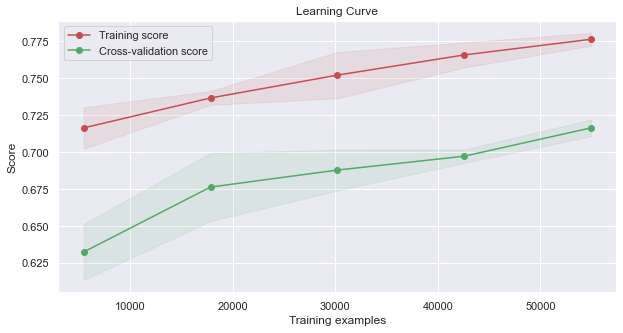

In [72]:
plot_learning_curve(rand_search.best_estimator_, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# plt.savefig('plots/learning_curve.png', dpi=300)

This learning curve shows that with more samples (data points), the score improves. Therefore, the model is learning something from the data and improving as it gets more information.

### Validation Curve

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Validation Curve with <class 'sklearn.tree._classes.DecisionTreeClassifier'>"}, xlabel='max_depth', ylabel='f1'>)

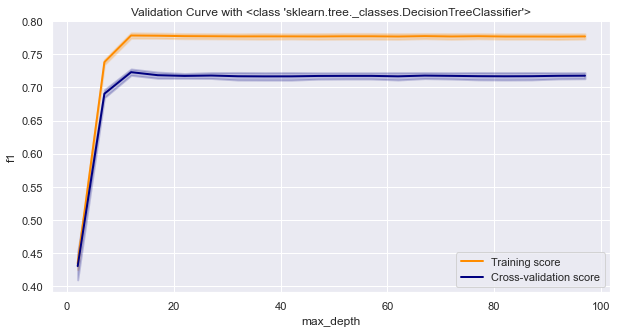

In [74]:
# max_depth validation curve
plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=5, scoring='f1', param_name='max_depth', param_range= range(2,100,5), n_jobs=-1)
# plt.savefig('plots/max_depth_validation_curve.png',dpi=300)

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Validation Curve with <class 'sklearn.tree._classes.DecisionTreeClassifier'>"}, xlabel='min_samples_leaf', ylabel='f1'>)

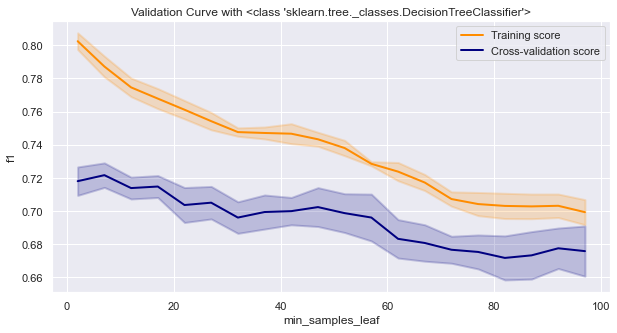

In [75]:
# min_samples_leaf validation curve
plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=5, scoring='f1', param_name='min_samples_leaf', param_range= range(2,100,5), n_jobs=-1)
# plt.savefig('plots/min_samples_leaf_validation_curve.png',dpi=300)

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Validation Curve with <class 'sklearn.tree._classes.DecisionTreeClassifier'>"}, xlabel='min_samples_split', ylabel='f1'>)

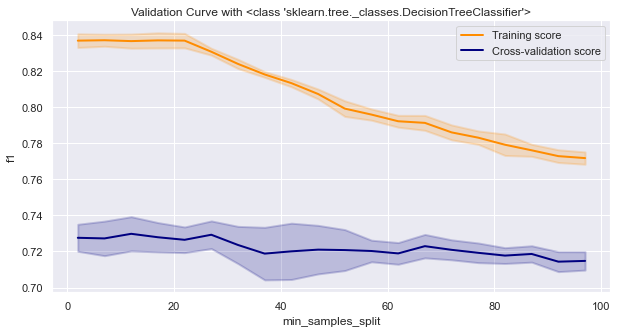

In [76]:
# min_samples_split validation curve
plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=5, scoring = 'f1', param_name='min_samples_split', param_range= range(2,100,5), n_jobs=-1)
# plt.savefig('plots/min_samples_split_validation_curve.png',dpi=300)

### Feature Importances

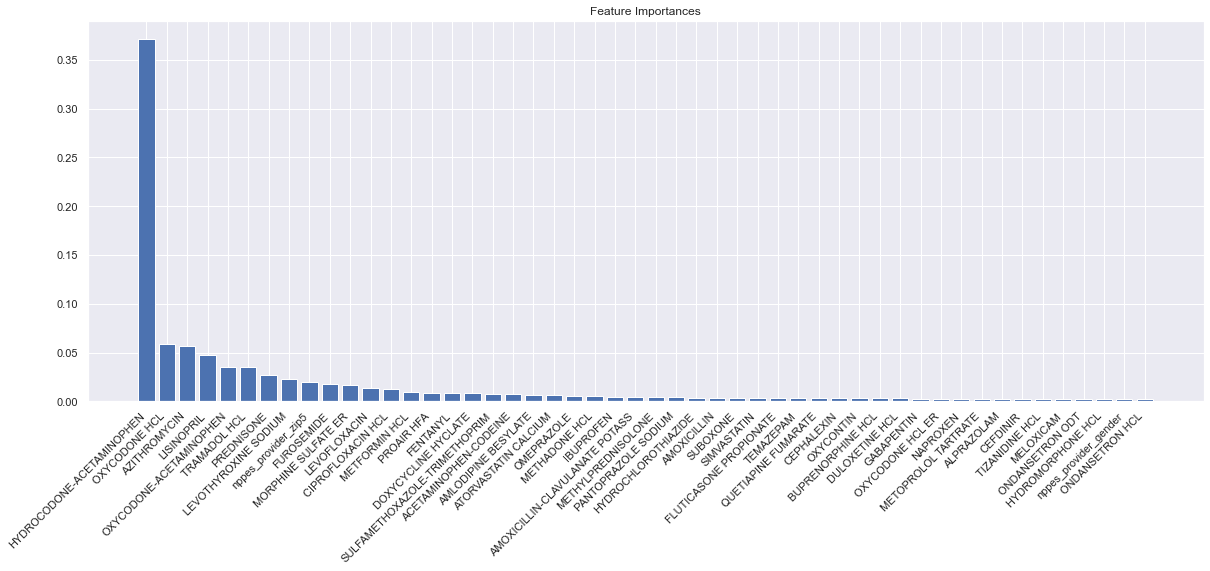

In [77]:
# see the top 50 most important features in classifying overprescribers
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

names = [X.columns[i] for i in indices]

fig, axes = plt.subplots(figsize=(20,7))
axes.set_title('Feature Importances')
axes.bar(range(50), importances[indices][:50])
axes.set_xticks(range(50))
axes.set_xticklabels(names[:50], rotation=45, ha='right')
# if you want to save the figure, uncomment below and update the path
# plt.savefig('plots/feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

## Final model

We now create a new model using the tuned hyperparameters that seemed to produce the best results

In [78]:
model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=12, min_samples_split = 42, random_state=7)

In [79]:
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=12, min_samples_split=42,
                       random_state=7)

In [80]:
labels = model.predict(X_test)
print(f'The f1 score for this model is: {f1_score(y_test, labels)}')

The f1 score for this model is: 0.7396193771626298


The f1 score for our final model using the test sets was 0.739, which was not bad. It got to about the same scores as when we implemented a cross validator on the model without any changes. Again, we need to remember that these are arbitrary target labels, using outlier thresholds that we calculated earlier. 

In conclusion, our Decision Tree Classifier was able to learn information from the data and was able to attain a 0.739 f1-score in determining which prescribers are "overprescribers". The score can be improved if we used an ensemble such as Random Forest Classifier. I only decided to stick with Decision Tree Classifier due to lack of computing power and time.

## <u>Clustering</u>

We move on to unsupervised learning by starting with KMeans and DBSCAN clustering to see if there are any interesting clusters in the data. 

In [81]:
scaler = StandardScaler()
# remove gender and zip code columns since we don't want those scaled
X_scaled = scaler.fit_transform(X)

In [82]:
pd.DataFrame(X_scaled, columns=X.columns).head()

,ABACAVIR,ABACAVIR-LAMIVUDINE-ZIDOVUDINE,ABILIFY,ABILIFY MAINTENA,ACARBOSE,ACEBUTOLOL HCL,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACETIC ACID,ACETYLCYSTEINE,ACIPHEX,...,ZOLOFT,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZONISAMIDE,ZORVOLEX,ZOSTAVAX,ZOSYN,ZUBSOLV,ZYPREXA,nppes_provider_gender,nppes_provider_zip5
0,-0.033614,-0.021381,-0.182503,-0.016364,-0.08954,-0.084297,-0.28736,-0.075382,-0.040178,-0.035338,-0.04913,...,-0.035208,-0.619256,-0.16946,-0.09292,-0.024147,-0.019468,-0.012594,-0.017973,-0.027351,-0.805406,-1.303917
1,-0.033614,-0.021381,-0.182503,-0.016364,-0.08954,-0.084297,-0.28736,-0.075382,-0.040178,-0.035338,-0.04913,...,-0.035208,1.218305,-0.16946,-0.09292,-0.024147,-0.019468,-0.012594,-0.017973,-0.027351,-0.805406,-0.716385
2,-0.033614,-0.021381,-0.182503,-0.016364,-0.08954,-0.084297,-0.28736,-0.075382,-0.040178,-0.035338,-0.04913,...,-0.035208,0.870658,-0.16946,-0.09292,-0.024147,-0.019468,-0.012594,-0.017973,-0.027351,1.241610,-0.456098
3,-0.033614,-0.021381,-0.182503,-0.016364,-0.08954,-0.084297,-0.28736,-0.075382,-0.040178,-0.035338,-0.04913,...,-0.035208,-0.619256,-0.16946,-0.09292,-0.024147,-0.019468,-0.012594,-0.017973,-0.027351,-0.805406,1.393305
4,-0.033614,-0.021381,-0.182503,-0.016364,-0.08954,-0.084297,-0.28736,-0.075382,-0.040178,-0.035338,-0.04913,...,-0.035208,-0.619256,-0.16946,-0.09292,-0.024147,-0.019468,-0.012594,-0.017973,-0.027351,1.241610,0.948693


### KMeans

In [56]:
# for i in range(2,8):
#     kmeans = KMeans(n_clusters=i, n_jobs=-1)
#     kmeans.fit(X_scaled)
#     labels = kmeans.predict(X_scaled)
#     ss = silhouette_score(X_scaled, labels)
#     print(f'For {i} clusters, the silhouette score is {ss}')

(Printed out here so we don't need to re-run the for-loop)

For 2 clusters, the silhouette score is 0.5643087215347616

For 3 clusters, the silhouette score is 0.45715028061425217

For 4 clusters, the silhouette score is 0.3613106484425875

For 5 clusters, the silhouette score is 0.3428324301731485

For 6 clusters, the silhouette score is 0.3522330075126977

For 7 clusters, the silhouette score is 0.4389452085192393

In [83]:
kmeans = KMeans(n_clusters = 2, random_state = 3, n_jobs=-1)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)

c:\users\arnold\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [84]:
silhouette_score(X_scaled, labels)

0.5646411157898252

Silhouette score shows there are clear separations. Let's look into what they center around.

#### Plotting centroids

In [53]:
centers = kmeans.cluster_centers_
print(centers.shape)
print(centers)

(2, 1085)
[[-0.0023336  -0.0033425  -0.12298542 ... -0.0122979   0.05767389
   0.02549291]
 [ 0.01824881  0.02613845  0.96175065 ...  0.09617001 -0.451012
  -0.19935554]]


In [89]:
# plotting only the top 50 values for each cluster
def plot_centroids(centers):
    df = pd.DataFrame(centers, columns = X.columns)
    df = df.sort_values(by=1,axis=1, ascending = False)
    df = df.iloc[:,:50]
    df.plot(kind = 'bar', figsize = (36,12))
    plt.legend(loc='best', bbox_to_anchor=(0.8, 0.1, 0.5, 0.5)); # bbox is (x,y, width, height)

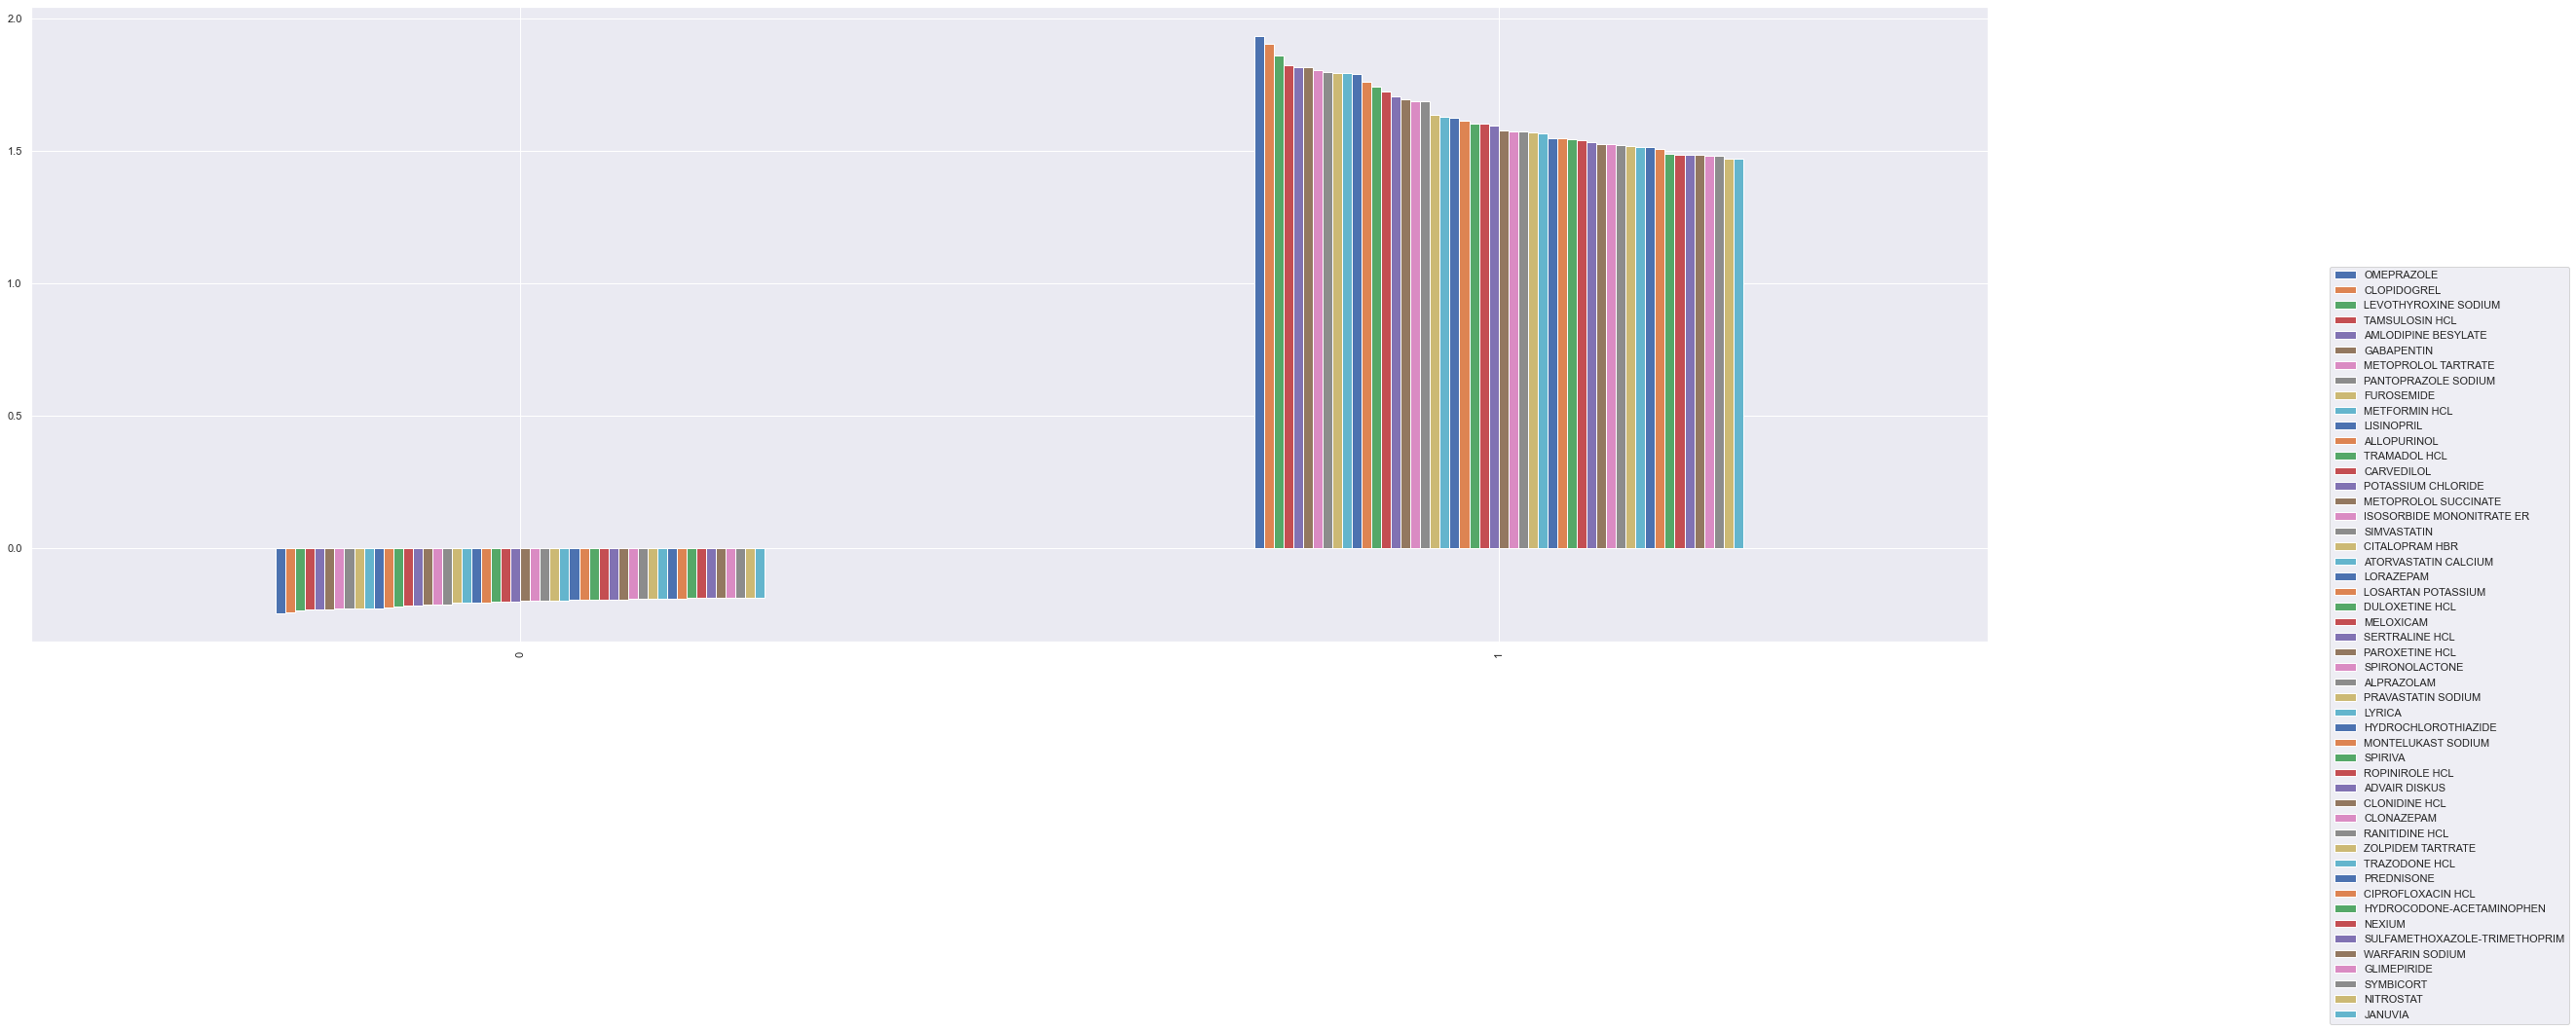

In [54]:
# 2 clusters
plot_centroids(centers)

We try it with 3 clusters.

In [88]:
kmeans3 = KMeans(n_clusters=3, random_state=3, n_jobs=-1)
kmeans3.fit(X_scaled)
labels3 = kmeans3.predict(X_scaled)

c:\users\arnold\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [59]:
centers3 = kmeans3.cluster_centers_
print(centers3.shape)
print(centers3)

(3, 1085)
[[ 0.01987895  0.02885253  0.33532289 ...  0.04895304 -0.37957008
  -0.15501252]
 [-0.00567433 -0.00700714 -0.14078447 ... -0.01445784  0.09571481
   0.0394069 ]
 [ 0.07749936  0.02291939  4.5926045  ...  0.22616338 -0.55900582
  -0.25147052]]


In [89]:
pd.Series(labels3).unique()

array([1, 2, 0])

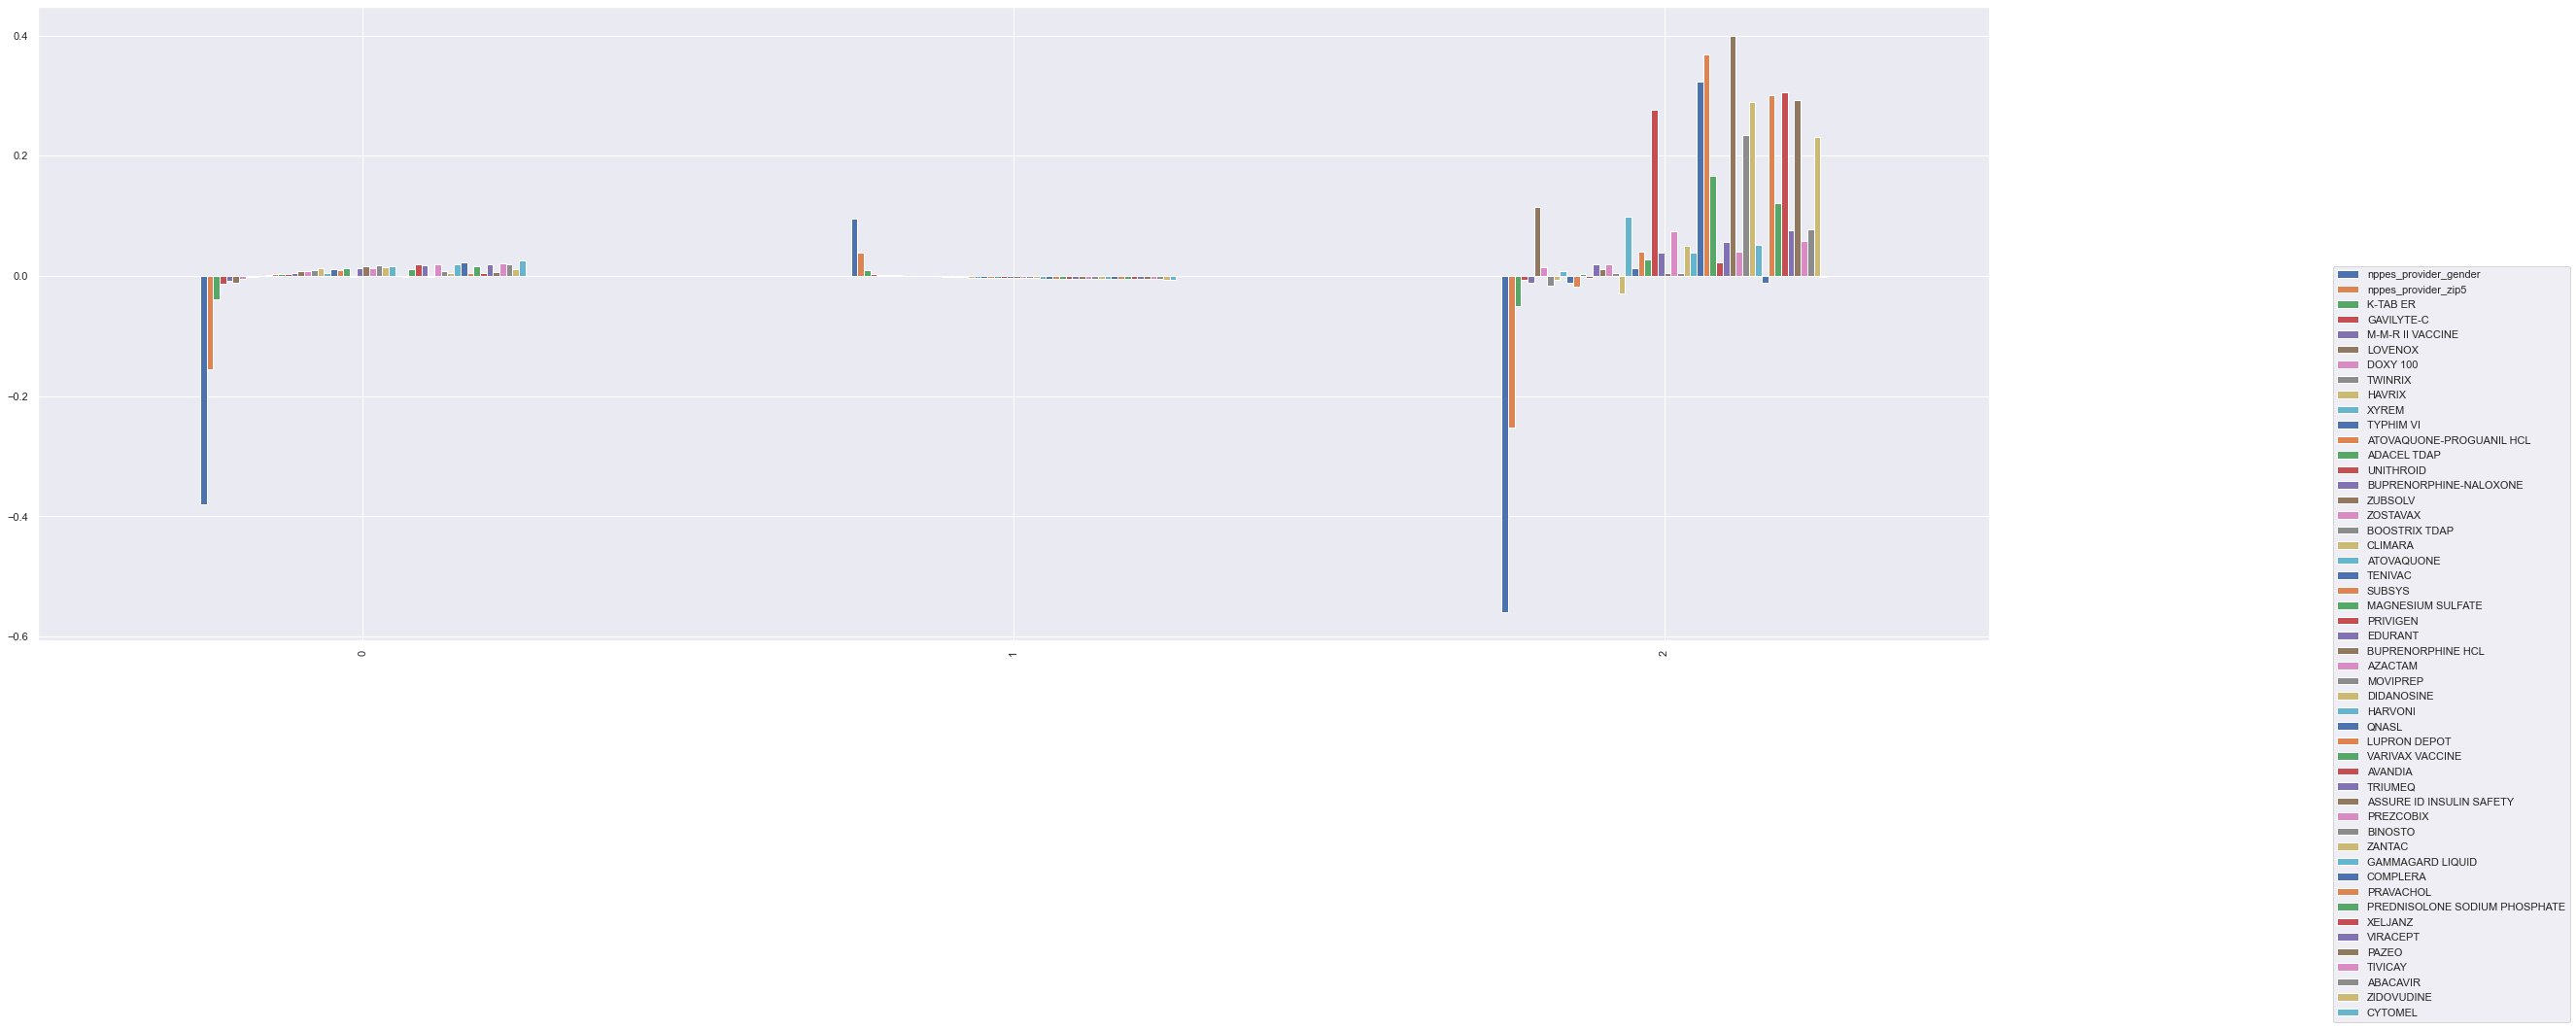

In [60]:
# 3 clusters
plot_centroids(centers3)

It is really interesting to find that though 2 clusters is the best for KMeans in terms of silhouette score (0.56), 3 clusters (silhouette score 0.46) shows different cluster centers around different features (gender and zip code)

The silhouette score seemed to decrease from 2-6, but at 7 clusters, the silhouette score increases, so I thought we should investigate.

In [85]:
kmeans7 = KMeans(n_clusters=7, n_jobs=-1)
kmeans7.fit(X_scaled)
labels7 = kmeans7.predict(X_scaled)

c:\users\arnold\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [86]:
centers7 = kmeans7.cluster_centers_
print(centers7.shape)
print(centers7)

(7, 1085)
[[-1.85771683e-02 -2.51208205e-03  3.10274781e-02 ...  1.16856012e-02
  -2.36565710e-01 -6.84948653e-02]
 [ 4.75663973e-02  8.65788202e-03  4.63233999e+00 ...  1.62835032e-01
  -5.61537565e-01 -3.06442478e-01]
 [ 2.29771694e+01  1.36065385e+01  2.68355137e-01 ... -2.73509232e-02
  -3.06773808e-01  2.48179137e-01]
 ...
 [-2.01843272e-02 -1.46922628e-02 -1.56994976e-01 ... -1.52642189e-02
   1.42998446e-01  5.00584115e-02]
 [-3.36136231e-02 -2.13809806e-02  1.87481288e+00 ...  1.14421712e+00
  -2.39783073e-01  2.88811058e-01]
 [-9.38682672e-03 -5.51175309e-03  7.51437447e-01 ...  7.91366427e-02
  -4.79744265e-01 -2.18652494e-01]]


In [87]:
k7_ss = silhouette_score(X_scaled, labels7)
print(k7_ss)

0.3170261160348048


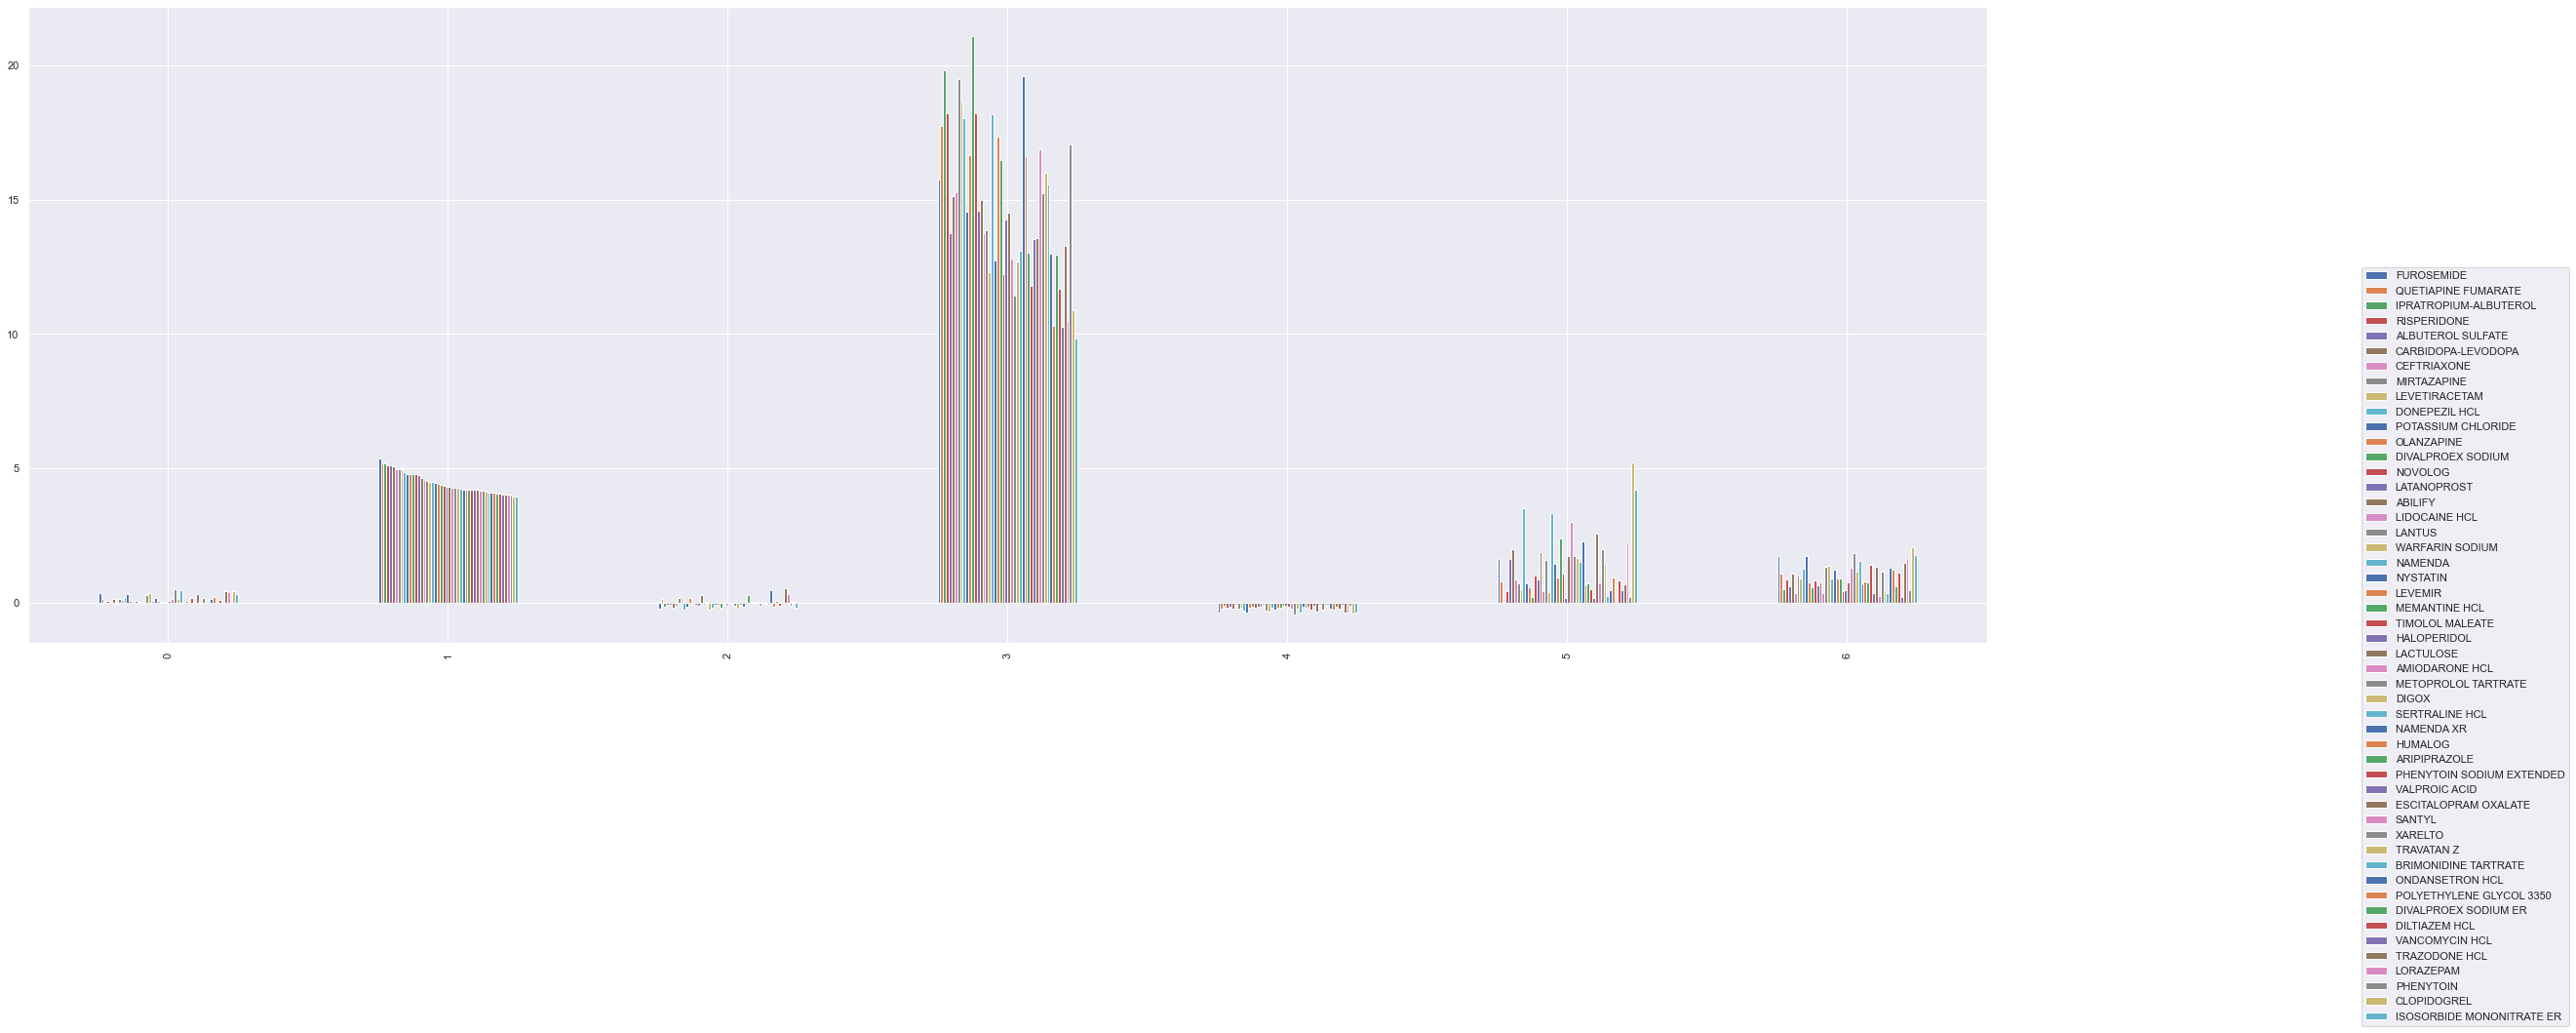

In [90]:
plot_centroids(centers7)

From the looks of it, there don't seem to be any intuition as to where these are plotted. Granted, our plot_centroids function only takes 50 of the most important columns. There could be other columns we are missing, but plotting all 1000+ columns would be difficult to visualize.

### DBSCAN

Next, we try DBSCAN, which is another clustering method.

In [43]:
db = DBSCAN(eps=1.5, min_samples=10, n_jobs=-1)

In [44]:
db.fit(X_scaled)

DBSCAN(eps=1.5, min_samples=10, n_jobs=-1)

In [45]:
# remove noisy data (-1's)
db_labels = db.labels_[db.labels_ != -1]
db_labels

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [46]:
x_no_noise = X_scaled[db.labels_ != -1]

In [47]:
db_silhouette = silhouette_score(x_no_noise, db_labels)
db_silhouette

0.24404771383734197

In [48]:
# Visualize the clusters and their amounts
uniques, counts = np.unique(db.labels_, return_counts=True)
print(uniques, counts)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [79949  9460  8344    24    26    20    75    23    16    16    12    22
    10    23    11    13     9    17]


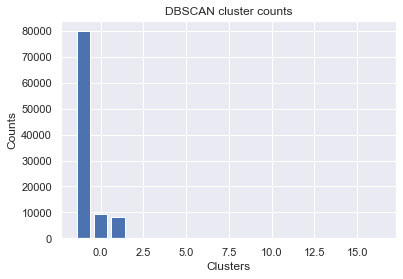

In [49]:
fig = plt.figure()
plt.bar(uniques, counts)
plt.title('DBSCAN cluster counts')
plt.xlabel('Clusters')
plt.ylabel('Counts')
plt.show()

After playing around with the hyperparameters, it seems like with hyperparameters set at eps=1.5 and min_samples = 10, we have about 7 clusters. We also have a lot of noisy data (56,000 datapoints are noisy and not classified). Majority of the data was noisy. The number of noisy datapoints did not change significantly as we adjusted the hyperparameters, leading me to believe clustering may not be the best method with this dataset. 

In conclusion, clustering and unsupervised learning are probably not the best way to go about analyzing this data.

## Principal Component Analysis

Lastly, we implement a PCA to also try to visualize the data in 2-D.

In [67]:
from sklearn.decomposition import PCA

In [68]:
pca = PCA()
pca.fit(X_scaled)

PCA()

In [75]:
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''
    fig, ax = plt.subplots(1, 1, figsize=(20, 6))

    
    scree = pca.explained_variance_ratio_*100
    ax.bar(np.arange(len(scree))+1, scree)
    ax.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    ax.set_xlabel("Principal components")
    ax.set_ylabel("Percentage explained variance")
    ax.set_title("Scree plot")
    # plt.savefig('plots/scree.png', dpi=300)
    return ax

<AxesSubplot:title={'center':'Scree plot'}, xlabel='Principal components', ylabel='Percentage explained variance'>

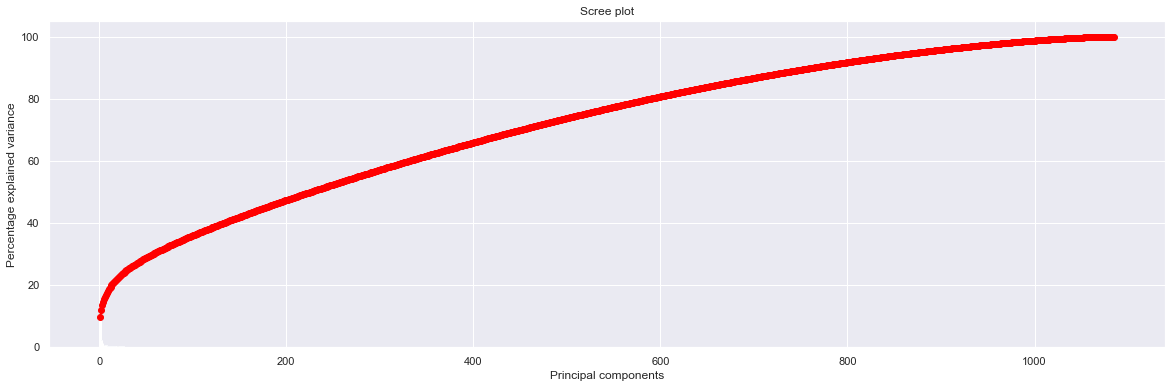

In [72]:
display_scree_plot(pca)

We see here that with the scree plot, we can get about 80% variance by dropping 400 (or about 40%) of the PCA components

In [73]:
x_trans_pca = pca.transform(X_scaled)

In [74]:
x_trans_pca.shape

(98070, 1085)

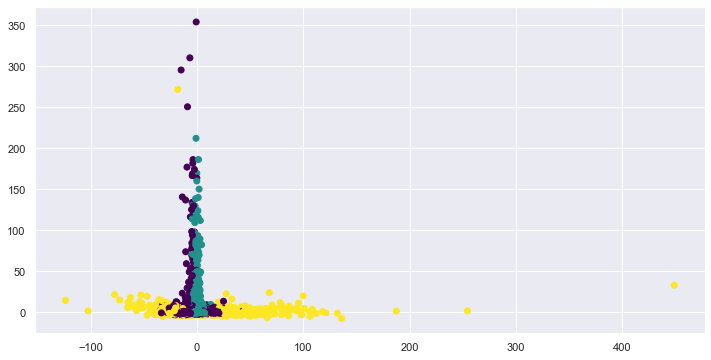

In [93]:
# visualize the PCA components and see if there are any patterns or visible clusters
# labels is from KMeans 3 clusters
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(x_trans_pca[:,0], x_trans_pca[:,1], c=labels3, cmap = 'viridis', )
# plt.savefig('plots/PCA_0_1_dim.png')

In [59]:
def plot_pca_comps(pca_item, num_dims, data):
    
    variance_ratios = pca_item.explained_variance_ratio_
    components = pd.DataFrame(pca_item.components_[:num_dims], columns = data.columns)
    
    fig, ax = plt.subplots(figsize = (14,8))
    
    components.plot(ax=ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    dims = [f'Dimension {i}' for i in range(num_dims)]
    ax.set_xticklabels(labels =dims,rotation=0)
    
    # Display the explained variance ratios
    for i, ev in enumerate(pca_item.explained_variance_ratio_[:num_dims]):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, f"Explained Variance\n {np.round(ev,4)}")

    ax.legend(loc='best', bbox_to_anchor=(0.75, 0.1, 0.5, 0.5)) # bbox is (x,y, width, height)
    


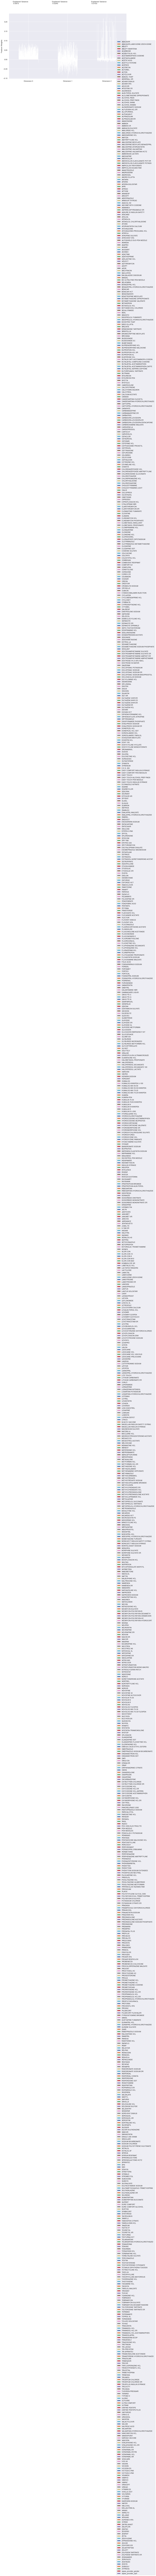

In [130]:
plot_pca_comps(pca, 3, X)

## Conclusion

Of the models we've implemented, only our Decision Tree (supervised learning) seems to have produced some promising results. Clustering and unsupervised learning didn't seem to reveal anything in our dataset. 

#### Further consideration
If I were to do this project again, I would hope to be able to have more resources and gather more pertinent data  related to labeling the doctors. Again, this dataset only contains Medicare/Medicaid claims, and misses out on a large proportion of the total prescriptions. If I had access to it, I would try to acquire pharmacy prescription dispensing data, which would give a more accurate picture regardless of what payor or insurance (or cash) they used. I would also scrape government websites that contain records of misconduct for providers regarding opioids, or even gather data pertaining to features of the prescriber (what medical school they attended, how much schooling, religious affiliations, etc.) to see how these would help in predicting which providers tend to prescribe more opioids. 
To further investigate the data, I would try other algorithms that may perform better for this data, do a market basket analysis, or even plot all of the opioid prescribers on a map of the USA. 
The implications of the scope of this project are great - if we can build a successful model, we can effectively reduce the impact of the opioid epidemic, prevent further diversion and or illegitimate prescribing, and save many lives.